In [18]:
%run ../common_functions.py

read_dataset()
read_all_datasets()
read_processed_data()
combine_text_columns()
split_train_test()
extract_data()
evaluate_model()
detect_missing_values()


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
import torch

## Load in Dataset

In [5]:
data = read_processed_data(balanced=True).sample(n=30_000)

## Preprocess

### Split data

In [6]:
train_data, test_data = split_train_test(data=data, test_size=0.2)

## Train Random Forest

### Extract data and label mapping

In [7]:
X_train, y_train, X_test, y_test = extract_data(train_df=train_data, test_df=test_data, text_col='text', label_col='label')

### Convert text to vectors

In [9]:
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.mps.is_available()
                      else "cpu")
print(f"Using device >> {device}")

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embedder = embedder.to(device)

X_train_emb = embedder.encode(
    X_train, batch_size=48, show_progress_bar=True, device=device
)

X_test_emb = embedder.encode(
    X_test, batch_size=48, device=device
)

Batches:   0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
model = RandomForestClassifier(
    n_estimators=400,
    criterion='entropy',
    max_features='sqrt',
    class_weight='balanced',
    bootstrap=True
)
model.fit(X_train_emb, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=400)

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.70      0.68      2990
           1       0.69      0.65      0.67      3010

    accuracy                           0.67      6000
   macro avg       0.68      0.67      0.67      6000
weighted avg       0.68      0.67      0.67      6000


Overall Metrics:
Accuracy       : 0.6745
Precision (avg): 0.6750
Recall    (avg): 0.6745
F1 Score  (avg): 0.6743



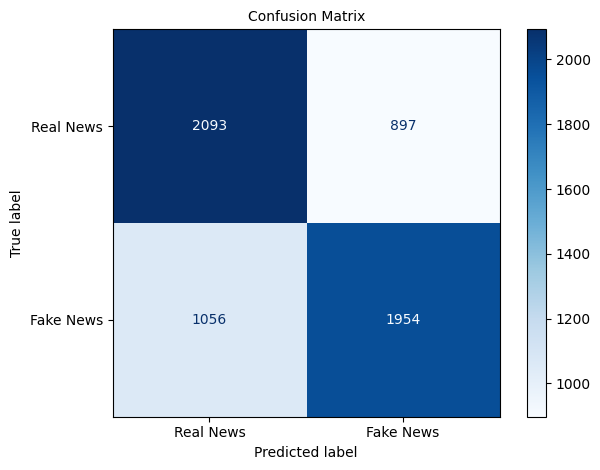

In [19]:
y_pred = model.predict(X_test_emb)

evaluate_model(y_test=y_test, y_pred=y_pred)